Gerando gráficos com a previsão definida...


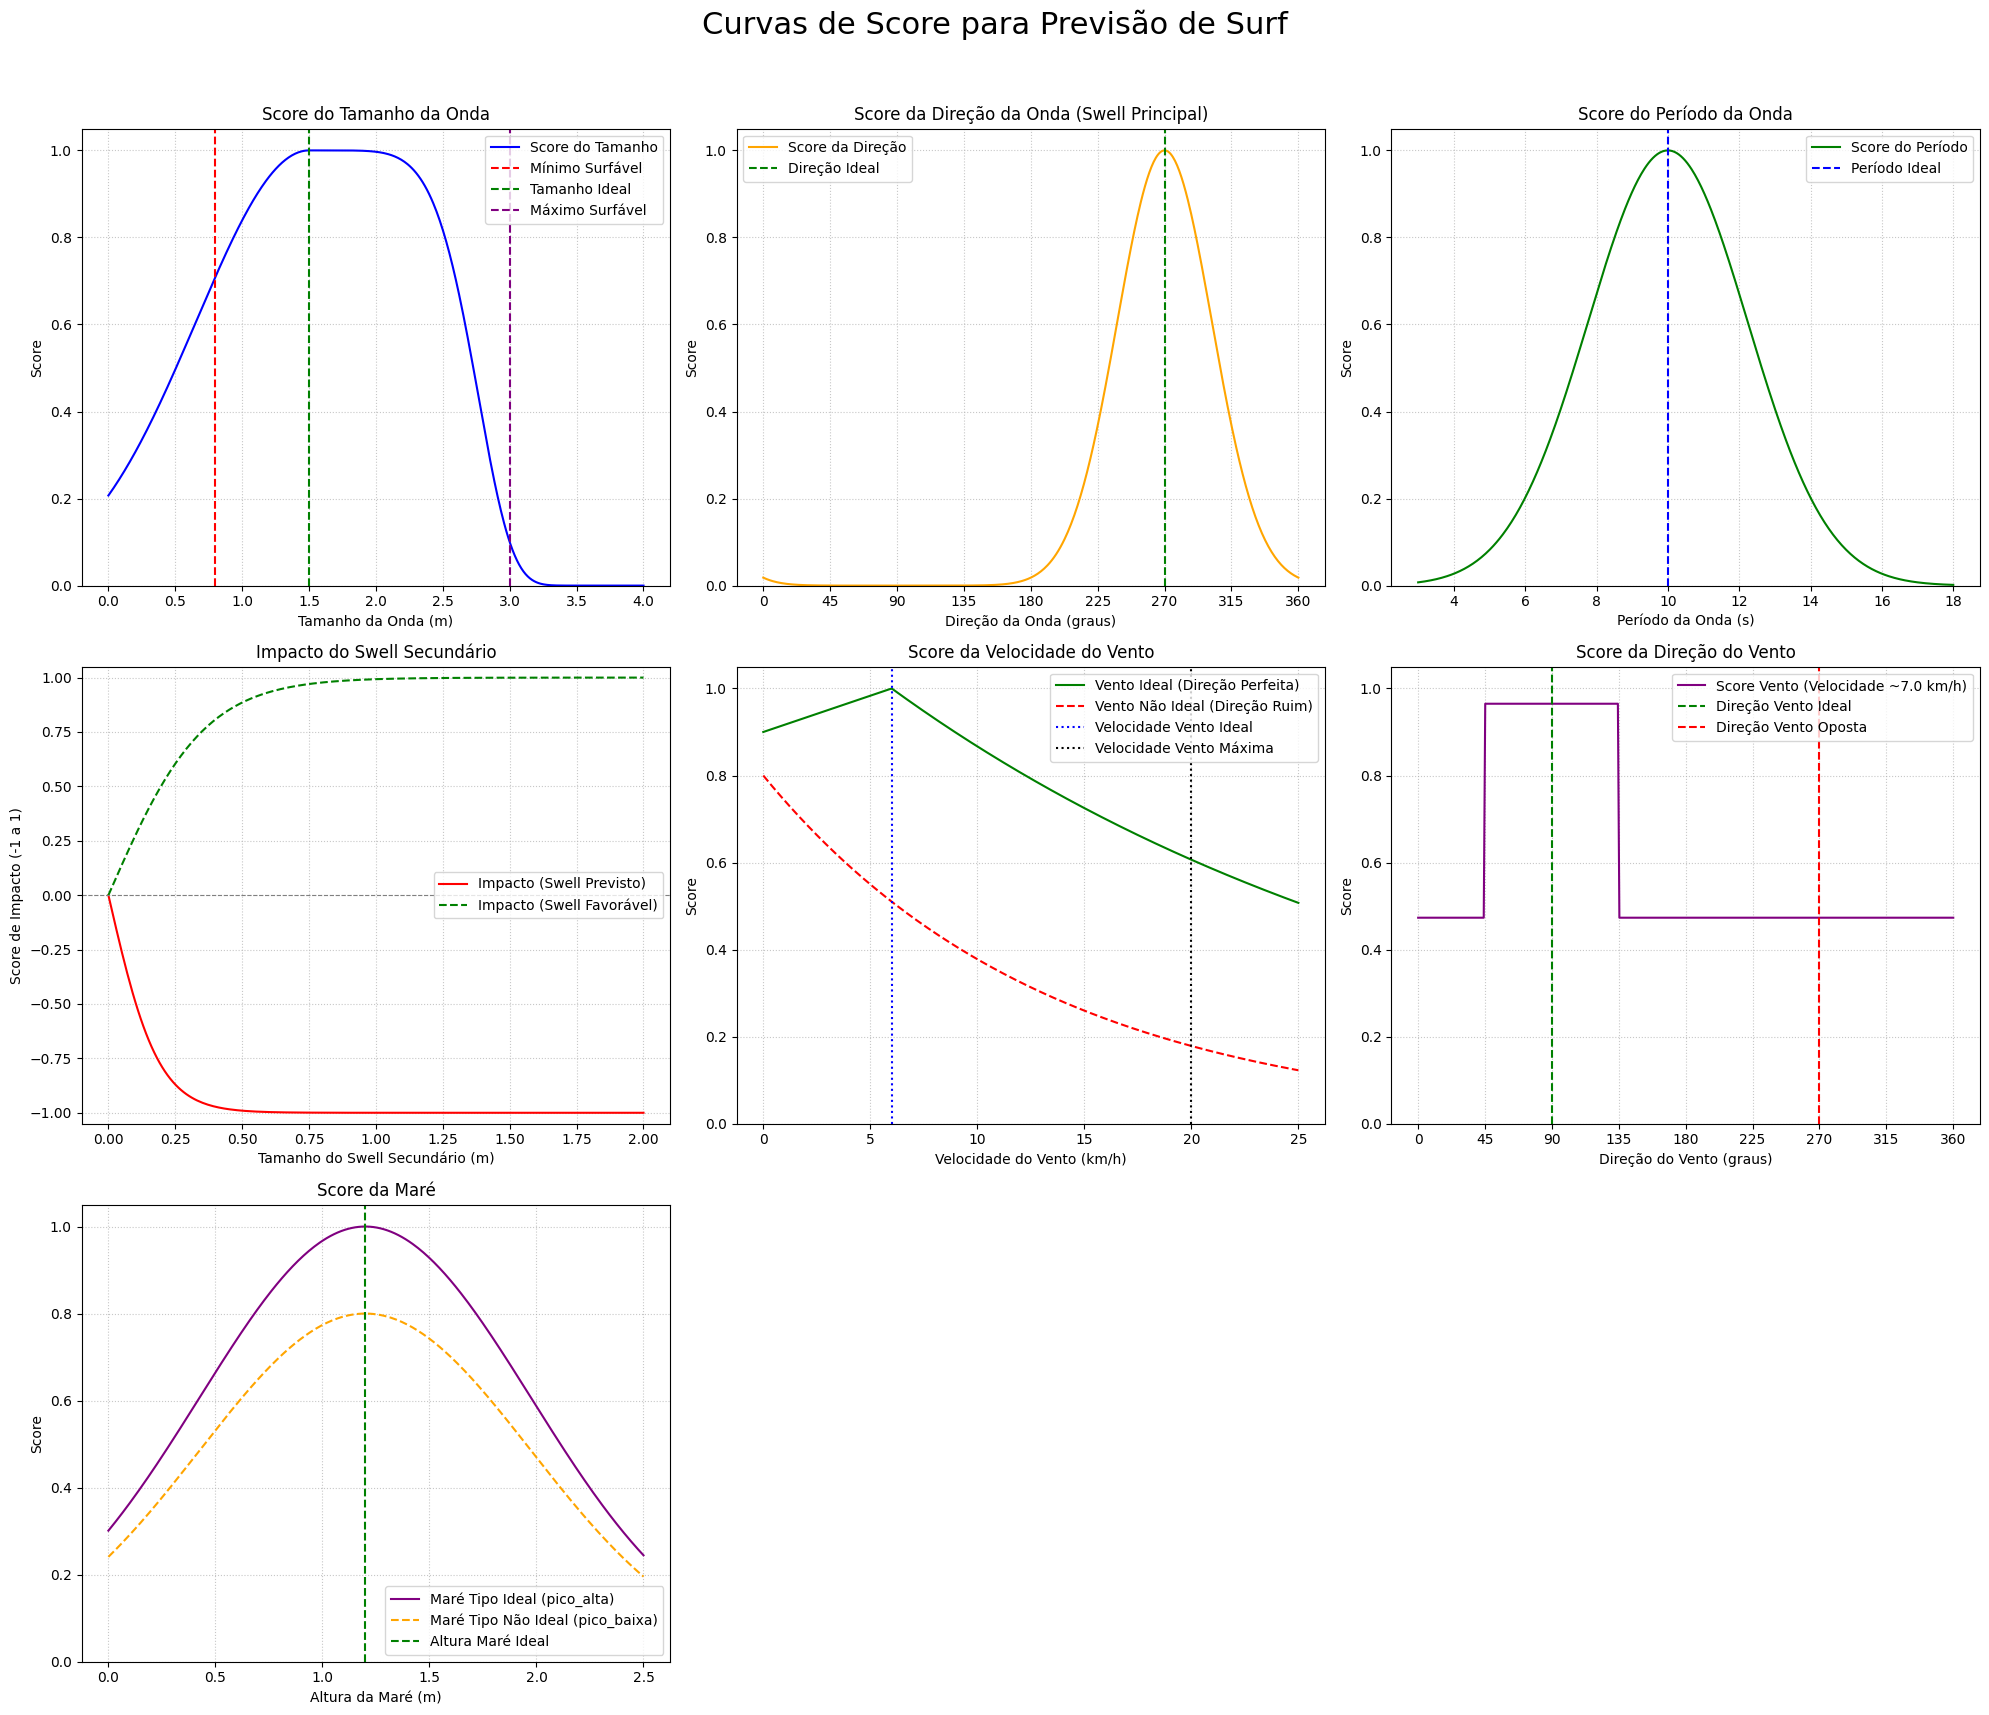

Geração de gráficos concluída.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importar as funções de score dos arquivos separados
# Certifique-se que esses arquivos estão no mesmo diretório ou no seu PYTHONPATH
from wave_score import (
    calcular_score_tamanho_onda,
    calcular_score_direcao_onda,
    calcular_score_periodo_onda,
    calcular_impacto_swell_secundario
)
from wind_score import calcular_score_vento
from tide_score import calcular_score_mare

# --- Previsões (Exemplo para Geração de Gráficos) ---
previsao_onda_principal = {
    'tamanho': 1.8,
    'periodo': 9.0,
    'direcao': 270.0 # Ex: SW
}

previsao_swell_secundario = {
    'tamanho': 0.7,
    'periodo': 5.0,
    'direcao': 90.0 # Ex: L
}

parametros_score = {
    'tamanho': {'minimo': 0.8, 'ideal': 1.5, 'maximo': 3.0},
    'direcao': {'ideal': 270.0}, # Direção ideal do swell principal
    'periodo': {'ideal': 10.0}
}

parametros_vento = {
    'ideal_direcao': 90.0, # Ex: Offshore Leste (para uma praia que abre para o Oeste)
    'ideal_velocidade': 6.0, # km/h
    'max_velocidade': 20.0 # km/h (velocidade a partir da qual o vento é muito ruim)
}

parametros_mare = {
    'mare_ideal': 1.2, # em metros (altura da maré ideal)
    'mare_tipo_ideal': 'pico_alta', # Pode ser 'enchente', 'vazante', 'pico_alta', 'pico_baixa'
}

print("Gerando gráficos com a previsão definida...")

# --- Dados para Curvas de Ondas ---
tamanhos_plot = np.linspace(0, 4.0, 500)
scores_tamanho = calcular_score_tamanho_onda(
    tamanhos_plot,
    parametros_score['tamanho']['minimo'],
    parametros_score['tamanho']['ideal'],
    parametros_score['tamanho']['maximo']
)

direcoes_plot = np.linspace(0, 360, 500)
scores_direcao = calcular_score_direcao_onda(
    direcoes_plot,
    parametros_score['direcao']['ideal']
)

periodos_plot = np.linspace(3.0, 18.0, 500)
scores_periodo = calcular_score_periodo_onda(
    periodos_plot,
    parametros_score['periodo']['ideal']
)

# --- Dados para Curvas de Swell Secundário ---
tamanhos_swell_sec_impacto_plot = np.linspace(0, 2.0, 200)

# Simulação de impacto negativo (usando swell secundário previsto)
impactos_swell_secundario = calcular_impacto_swell_secundario(
    tamanhos_swell_sec_impacto_plot,
    previsao_swell_secundario['periodo'],
    previsao_swell_secundario['direcao'],
    previsao_onda_principal['tamanho'],
    previsao_onda_principal['periodo'],
    previsao_onda_principal['direcao']
)

# Simulação de impacto positivo (parâmetros que maximizam impacto positivo para visualização)
impactos_swell_secundario_positivo = calcular_impacto_swell_secundario(
    tamanhos_swell_sec_impacto_plot,
    12.0,       # período maior que o principal
    270.0,      # direção alinhada com o principal
    previsao_onda_principal['tamanho'],
    previsao_onda_principal['periodo'],
    previsao_onda_principal['direcao']
)

# --- Dados para Curvas de Vento ---
velocidades_plot = np.linspace(0, parametros_vento['max_velocidade'] + 5, 300)

# 1. Curva de VELOCIDADE do Vento para **Direção IDEAL**
# Força a direção do vento a ser a ideal, para que score_direction interno seja 1.0.
scores_vento_ideal = calcular_score_vento(
    velocidades_plot,
    np.full_like(velocidades_plot, parametros_vento['ideal_direcao']),
    parametros_vento['ideal_direcao'],
    ideal_wind_speed=parametros_vento['ideal_velocidade'],
    max_wind_speed=parametros_vento['max_velocidade']
)

# 2. Curva de VELOCIDADE do Vento para **Direção NÃO IDEAL**
# Força a direção do vento a ser a oposta, para que score_direction interno seja 0.0.
scores_vento_nao_ideal = calcular_score_vento(
    velocidades_plot,
    np.full_like(velocidades_plot, (parametros_vento['ideal_direcao'] + 180) % 360), # Direção oposta
    parametros_vento['ideal_direcao'],
    ideal_wind_speed=parametros_vento['ideal_velocidade'],
    max_wind_speed=parametros_vento['max_velocidade']
)

# 3. Curva de DIREÇÃO do Vento (com velocidade constante para isolar o efeito da direção)
velocidade_constante_para_direcao = parametros_vento['ideal_velocidade'] + 1
direcoes_vento_plot = np.linspace(0, 360, 360) # Uma direção para cada grau

scores_vento_direcao_variada = calcular_score_vento(
    np.full_like(direcoes_vento_plot, velocidade_constante_para_direcao),
    direcoes_vento_plot,
    parametros_vento['ideal_direcao'],
    ideal_wind_speed=parametros_vento['ideal_velocidade'],
    max_wind_speed=parametros_vento['max_velocidade']
)

# --- Dados para Curvas de Maré ---
alturas_mare = np.linspace(0, 2.5, 300)

tipos_mare_previsao_ideal = np.full_like(alturas_mare, parametros_mare['mare_tipo_ideal'], dtype=object)

# Determina o tipo de maré oposto para a curva "não ideal"
if parametros_mare['mare_tipo_ideal'] == 'pico_alta':
    tipo_oposto_mare = 'pico_baixa'
elif parametros_mare['mare_tipo_ideal'] == 'pico_baixa':
    tipo_oposto_mare = 'pico_alta'
elif parametros_mare['mare_tipo_ideal'] == 'enchente':
    tipo_oposto_mare = 'vazante'
else: # 'vazante'
    tipo_oposto_mare = 'enchente'

tipos_mare_previsao_nao_ideal = np.full_like(alturas_mare, tipo_oposto_mare, dtype=object)

scores_mare_ideal = calcular_score_mare(
    alturas_mare,
    parametros_mare['mare_ideal'],
    tipos_mare_previsao_ideal,
    parametros_mare['mare_tipo_ideal']
)

scores_mare_nao_ideal = calcular_score_mare(
    alturas_mare,
    parametros_mare['mare_ideal'],
    tipos_mare_previsao_nao_ideal,
    parametros_mare['mare_tipo_ideal']
)

### **Plotagem dos Gráficos**

plt.figure(figsize=(20, 18))
plt.suptitle('Curvas de Score para Previsão de Surf', fontsize=22, y=0.98) # Título geral para todos os subplots

# --- Subplot 1: Score do Tamanho da Onda ---
plt.subplot(3, 3, 1)
plt.plot(tamanhos_plot, scores_tamanho, color='blue', label='Score do Tamanho')
plt.axvline(parametros_score['tamanho']['minimo'], color='red', linestyle='--', label='Mínimo Surfável')
plt.axvline(parametros_score['tamanho']['ideal'], color='green', linestyle='--', label='Tamanho Ideal')
plt.axvline(parametros_score['tamanho']['maximo'], color='purple', linestyle='--', label='Máximo Surfável')
plt.title('Score do Tamanho da Onda')
plt.xlabel('Tamanho da Onda (m)')
plt.ylabel('Score')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.ylim(0, 1.05)

# --- Subplot 2: Score da Direção da Onda (Swell Principal) ---
plt.subplot(3, 3, 2)
plt.plot(direcoes_plot, scores_direcao, color='orange', label='Score da Direção')
plt.axvline(parametros_score['direcao']['ideal'], color='green', linestyle='--', label='Direção Ideal')
plt.title('Score da Direção da Onda (Swell Principal)')
plt.xlabel('Direção da Onda (graus)')
plt.ylabel('Score')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.ylim(0, 1.05)
plt.xticks(np.arange(0, 361, 45)) # Define os ticks para facilitar a leitura da direção

# --- Subplot 3: Score do Período da Onda ---
plt.subplot(3, 3, 3)
plt.plot(periodos_plot, scores_periodo, color='green', label='Score do Período')
plt.axvline(parametros_score['periodo']['ideal'], color='blue', linestyle='--', label='Período Ideal')
plt.title('Score do Período da Onda')
plt.xlabel('Período da Onda (s)')
plt.ylabel('Score')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.ylim(0, 1.05)

# --- Subplot 4: Impacto do Swell Secundário ---
plt.subplot(3, 3, 4)
plt.plot(tamanhos_swell_sec_impacto_plot, impactos_swell_secundario, color='red', label='Impacto (Swell Previsto)')
plt.plot(tamanhos_swell_sec_impacto_plot, impactos_swell_secundario_positivo, color='green', linestyle='--', label='Impacto (Swell Favorável)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Linha de zero para referência
plt.title('Impacto do Swell Secundário')
plt.xlabel('Tamanho do Swell Secundário (m)')
plt.ylabel('Score de Impacto (-1 a 1)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.ylim(-1.05, 1.05)

# --- Subplot 5: Score da Velocidade do Vento (Cenários de Direção) ---
plt.subplot(3, 3, 5)
plt.plot(velocidades_plot, scores_vento_ideal, color='green', label='Vento Ideal (Direção Perfeita)')
plt.plot(velocidades_plot, scores_vento_nao_ideal, color='red', linestyle='--', label='Vento Não Ideal (Direção Ruim)')
plt.axvline(parametros_vento['ideal_velocidade'], color='blue', linestyle=':', label='Velocidade Vento Ideal')
plt.axvline(parametros_vento['max_velocidade'], color='black', linestyle=':', label='Velocidade Vento Máxima')
plt.title('Score da Velocidade do Vento')
plt.xlabel('Velocidade do Vento (km/h)')
plt.ylabel('Score')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.ylim(0, 1.05)

# --- Subplot 6: Score da Direção do Vento (com Velocidade Constante) ---
# Mostra como o score *final* do vento varia com a direção,
# mantendo a velocidade constante para isolar o efeito da direção.
plt.subplot(3, 3, 6)
plt.plot(direcoes_vento_plot, scores_vento_direcao_variada, color='purple', label=f'Score Vento (Velocidade ~{velocidade_constante_para_direcao} km/h)')
plt.axvline(parametros_vento['ideal_direcao'], color='green', linestyle='--', label='Direção Vento Ideal')
plt.axvline((parametros_vento['ideal_direcao'] + 180) % 360, color='red', linestyle='--', label='Direção Vento Oposta')
plt.title('Score da Direção do Vento')
plt.xlabel('Direção do Vento (graus)')
plt.ylabel('Score')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.ylim(0, 1.05)
plt.xticks(np.arange(0, 361, 45))

# --- Subplot 7: Score da Maré ---
plt.subplot(3, 3, 7)
plt.plot(alturas_mare, scores_mare_ideal, color='purple', label=f'Maré Tipo Ideal ({parametros_mare["mare_tipo_ideal"]})')
plt.plot(alturas_mare, scores_mare_nao_ideal, color='orange', linestyle='--', label=f'Maré Tipo Não Ideal ({tipo_oposto_mare})')
plt.axvline(parametros_mare['mare_ideal'], color='green', linestyle='--', label='Altura Maré Ideal')
plt.title('Score da Maré')
plt.xlabel('Altura da Maré (m)')
plt.ylabel('Score')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.ylim(0, 1.05)

# Ajusta o layout para evitar sobreposição de títulos/rótulos
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("Geração de gráficos concluída.")

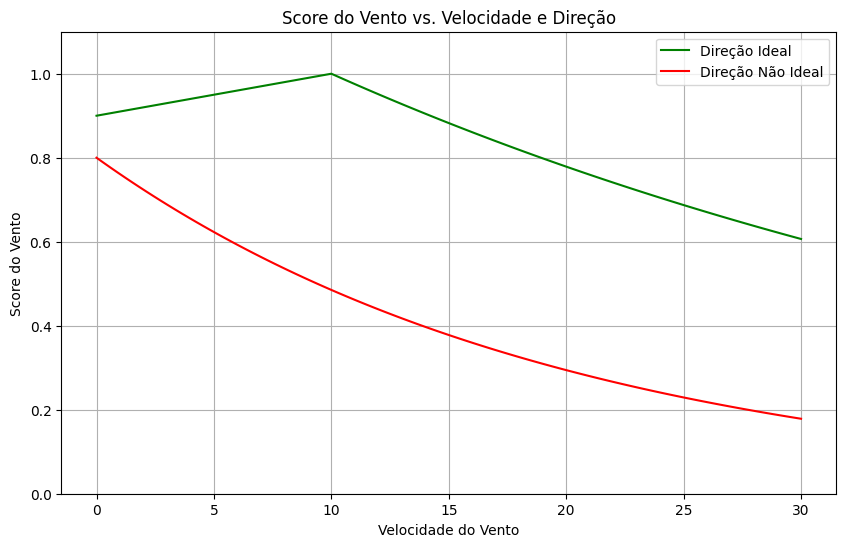

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from wind_score import calcular_score_vento

# Exemplo de uso:
wind_speeds = np.linspace(0, 30, 100) # Velocidades de 0 a 30 nós (ou km/h)
preferred_wind_dir_example = 90 # Vento Leste

# Testando com vento na direção ideal (ex: 90 graus)
wind_dirs_ideal = np.full_like(wind_speeds, preferred_wind_dir_example + 10) # ligeiramente fora, mas dentro do threshold
scores_ideal_dir = calcular_score_vento(
    wind_speed=wind_speeds,
    wind_dir=wind_dirs_ideal,
    preferred_wind_dir=preferred_wind_dir_example,
    ideal_wind_speed=10, # Velocidade ideal de 10
    max_wind_speed=30
)

# Testando com vento em direção não ideal (ex: 270 graus - Oeste)
wind_dirs_non_ideal = np.full_like(wind_speeds, preferred_wind_dir_example + 180) # Oposto ao ideal
scores_non_ideal_dir = calcular_score_vento(
    wind_speed=wind_speeds,
    wind_dir=wind_dirs_non_ideal,
    preferred_wind_dir=preferred_wind_dir_example,
    ideal_wind_speed=10,
    max_wind_speed=30
)

plt.figure(figsize=(10, 6))
plt.plot(wind_speeds, scores_ideal_dir, color='green', label='Direção Ideal')
plt.plot(wind_speeds, scores_non_ideal_dir, color='red', label='Direção Não Ideal')
plt.xlabel('Velocidade do Vento')
plt.ylabel('Score do Vento')
plt.title('Score do Vento vs. Velocidade e Direção')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()

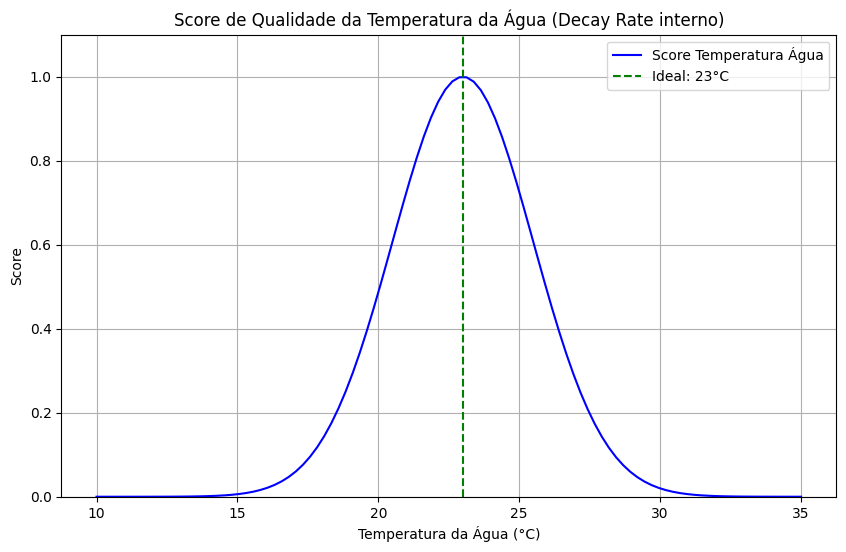

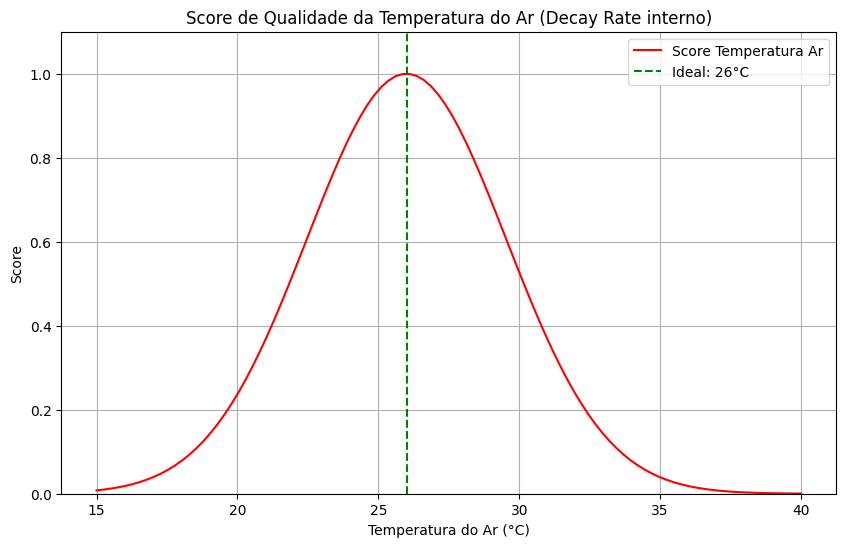

In [1]:
import matplotlib.pyplot as plt

from temperature_score import (
    calcular_score_temperatura_agua,
    calcular_score_temperatura_ar
)
import numpy as np

# Exemplo para Temperatura da Água
temps_agua = np.linspace(10, 35, 100) # Temperaturas de 10 a 35 Celsius
ideal_agua = 23 # Ideal 23°C

# Note que agora você não passa o decay_rate_agua diretamente na chamada
scores_agua = calcular_score_temperatura_agua(temps_agua, ideal_agua)

plt.figure(figsize=(10, 6))
plt.plot(temps_agua, scores_agua, color='blue', label='Score Temperatura Água')
plt.axvline(x=ideal_agua, color='green', linestyle='--', label=f'Ideal: {ideal_agua}°C')
plt.xlabel('Temperatura da Água (°C)')
plt.ylabel('Score')
plt.title(f'Score de Qualidade da Temperatura da Água (Decay Rate interno)')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()

# Exemplo para Temperatura do Ar
temps_ar = np.linspace(15, 40, 100) # Temperaturas de 15 a 40 Celsius
ideal_ar = 26 # Ideal 26°C

# Note que agora você não passa o decay_rate_ar diretamente na chamada
scores_ar = calcular_score_temperatura_ar(temps_ar, ideal_ar)

plt.figure(figsize=(10, 6))
plt.plot(temps_ar, scores_ar, color='red', label='Score Temperatura Ar')
plt.axvline(x=ideal_ar, color='green', linestyle='--', label=f'Ideal: {ideal_ar}°C')
plt.xlabel('Temperatura do Ar (°C)')
plt.ylabel('Score')
plt.title(f'Score de Qualidade da Temperatura do Ar (Decay Rate interno)')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()